# Time Series Analysis and Forecasting
**Dataset's objective:**

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores. What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Which model is the best?

This data comes from Kaggle, if you want to know more about it, kindly give a check to the [Competition Webpage](https://archive.ics.uci.edu/ml/datasets/Housing)
**Goals:**

* Explore the data (EDA, handle missing values etc).
* Perform extensive Time Series Analysis (seasonal decomposition and autocorrelation).
* Predict next 3 months of sales using SARIMAX, XGBoost and Prophet.
* Compare the models above.

This notebook mainly focuses on building a SARIMAX model, showing each step of it, from ARMA until SARIMAX. Then I use XGBoost and Prophet to compare results with SARIMAX and show how to tune each of the three to get big improvements on our predictions. 

We'll start with the reading in the data, analyzing missing values and understanding the basics of our dataset.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing
import datetime as dt #work with date type

#Visualisation frameworks
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from pylab import rcParams
plt.style.use('fivethirtyeight') # For plots

#Stats frameworks
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
#Setting parameters for all figures
rcParams['figure.figsize'] = 15, 5
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

# Loading Data and Basic EDA

Our dataset is from Kaggle: https://www.kaggle.com/c/demand-forecasting-kernels-only

We're going to import it and explore our data to see if we'll need to worry about data problems like missing values.

In [3]:
#Loading data :\n",
train = pd.read_csv('C:/Kaggle/train.csv')
test = pd.read_csv('C:/Kaggle/test.csv')
sub = pd.read_csv('C:/Kaggle/sample_submission.csv')

#Priting data shape
print ("Train has",train.shape[0],"sales and the following features:",train.columns.values)
print ("Test has",test.shape[0],"sales and the following features:",test.columns.values)

Train has 913000 sales and the following features: ['date' 'store' 'item' 'sales']
Test has 45000 sales and the following features: ['id' 'date' 'store' 'item']


In [4]:
# Store our test ID for easy access after and remove since it won't help us besides submitting the files
test_ID = test['id']
test = test.drop('id', axis=1)

print("Test now only have 3 features:", test.shape)

Test now only have 3 features: (45000, 3)


In [5]:
#Generate descriptive statistics of train dataset
train.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [6]:
#Checking if there is any missing value on train dataset
train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
#Generate descriptive statistics of test dataset
test.describe()

store         item
count  45000.000000  45000.00000
mean       5.500000     25.50000
std        2.872313     14.43103
min        1.000000      1.00000
25%        3.000000     13.00000
50%        5.500000     25.50000
75%        8.000000     38.00000
max       10.000000     50.00000

In [8]:
#Checking if there is any missing value on test dataset
test.isna().sum()

date     0
store    0
item     0
dtype: int64

<AxesSubplot:xlabel='store', ylabel='sales'>

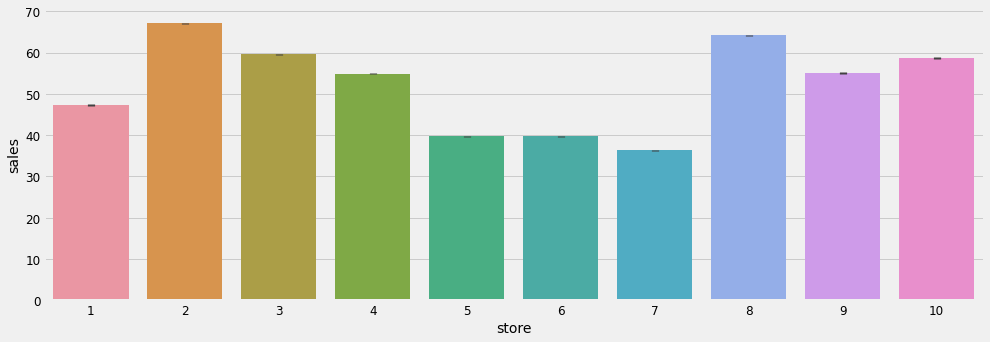

In [9]:
#Plotting total sales per Store
sns.barplot(x=train.store, y=train.sales)

In [10]:
#Check the period of time that our data is distributed 
print ("Our data in train dataset starts at:",train.date[0],"and finishes at", train.date.iloc[-1])

Our data in train dataset starts at: 2013-01-01 and finishes at 2017-12-31


So far we could see that our data doesn't have missing values, it is separated between 10 stores and the range of data goes from 2013 to the last day of 2017. We can start exploring further into our data.

# Feature Engineering and Time Series Analysis 

We saw that our dataset is apparently clean, so we without further ado, let's start our Time Series Analysis by doing basic Time Series stuff, which will be:
* Creating time series features
* Indexing our date column
* Analyzing our target variable

In [11]:
#Conterting the type of column date from Train dataset to date type
print('Before transformation dtype of date column:\n',train.date.dtype,'\n')

train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

print('After transformation dtype of date column:\n',train.date.dtype)

Before transformation dtype of date column:
 object 

After transformation dtype of date column:
 datetime64[ns]


In [12]:
#Creating new features so we can have a better understanding of data
train.loc[:, 'year'] = train['date'].dt.year #Making year column
train.loc[:, 'month'] = train['date'].dt.month #Month column
train.loc[:, 'weekofyear'] = train['date'].dt.week #Week number of the year column
train.loc[:, 'dayofweek'] = train['date'].dt.dayofweek #Day of the week column
train.loc[:, 'dayofyear'] = train['date'].dt.dayofyear
train.loc[:, 'weekend'] = (train.date.dt.weekday >= 5).astype(int) #Check if it's weekend or not

#As we are working with time series, a good practice is to set date as the index for our dataframe
train = train.set_index('date')

In [13]:
#Printing the first 7 rows of train dataset
train.head(7)

store  item  sales  year  month  weekofyear  dayofweek  dayofyear  \
date                                                                            
2013-01-01      1     1     13  2013      1           1          1          1   
2013-01-02      1     1     11  2013      1           1          2          2   
2013-01-03      1     1     14  2013      1           1          3          3   
2013-01-04      1     1     13  2013      1           1          4          4   
2013-01-05      1     1     10  2013      1           1          5          5   
2013-01-06      1     1     12  2013      1           1          6          6   
2013-01-07      1     1     10  2013      1           2          0          7   

            weekend  
date                 
2013-01-01        0  
2013-01-02        0  
2013-01-03        0  
2013-01-04        0  
2013-01-05        1  
2013-01-06        1  
2013-01-07        0

<AxesSubplot:xlabel='date', ylabel='sales'>

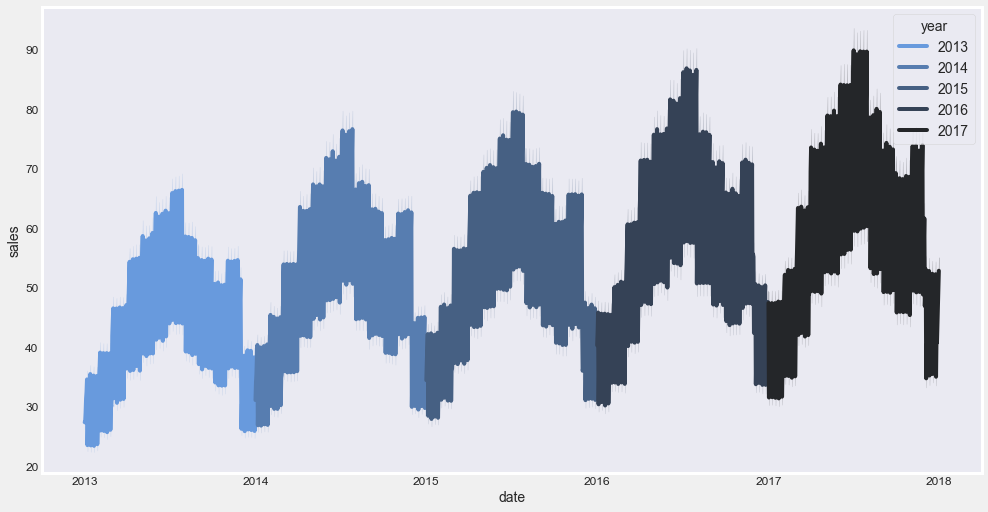

In [14]:
#Line plot of Sales graph over time

#Setting the figure size
plt.figure(figsize=(15, 8))

#Controlling figure aesthetics
sns.set_style('dark')
palette = sns.dark_palette("#689add", reverse=True, as_cmap=True)

#Draw a line plot between sales and date
sns.lineplot(x=train.index, y='sales', 
             hue='year', palette=palette, data=train)

First, lets understand some basic components of a time series:
* **Trend** - Consistent upwards or downwards slope of a time series.
* **Seasonality** - Clear periodic pattern of a time series(like sine funtion).
* **Noise** - Outliers or missing values.


 

Looking at the plot from above, we can notice that: 
1. It seems that there aren't many outliers on our data; 
2. We can clearly see a strong Seasonal pattern, repeating every 12 months;
3. There is an upward trend;
4. The structure between Trend, Seasonality and Noise seems to be more Additive rather than Multiplicative.



To check these issues more precisely, we can decompose each one.

train1 shape: (1826, 9)


<Figure size 1080x360 with 0 Axes>

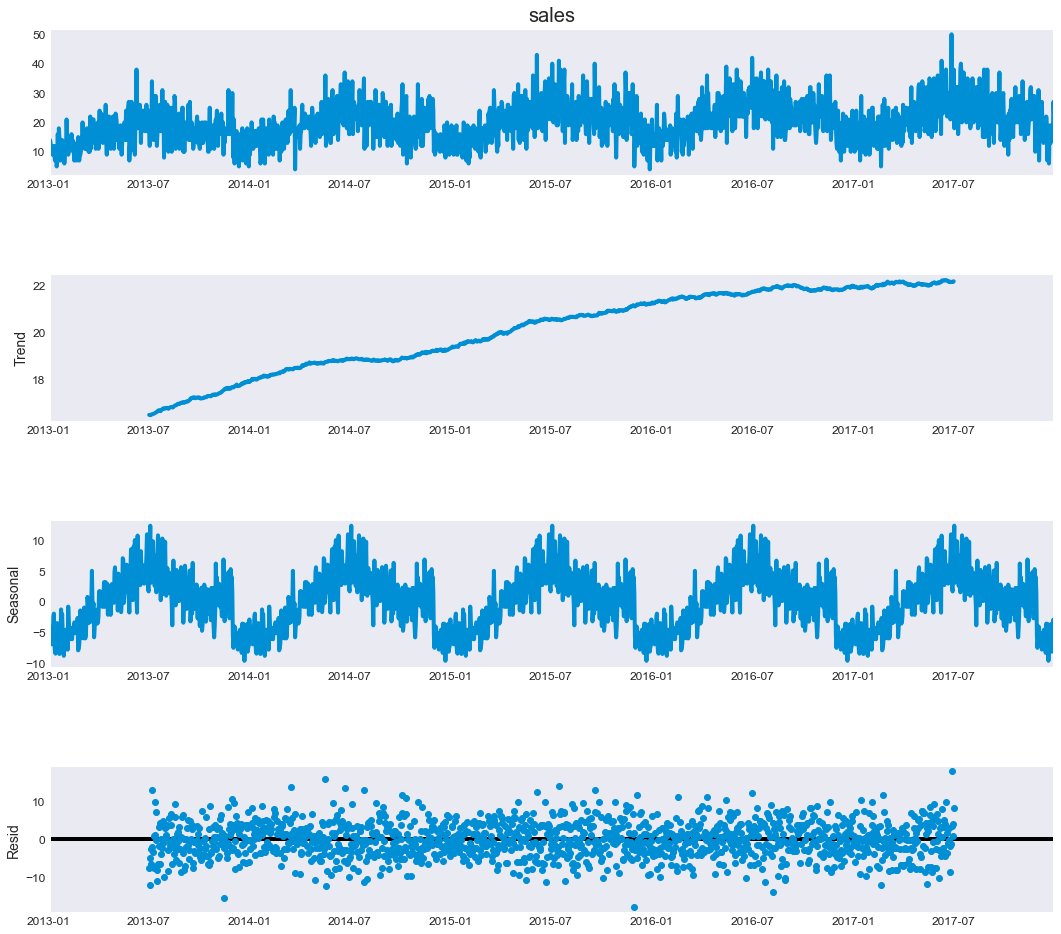

In [15]:
#As this dataset is huge, for analyzing trend, seasonality and residuals we'll use just one item and store to make things simpler and time-effecient.
train1 = train[train['store']==1]
train1 = train1[train1['item']==1]
print('train1 shape:', train1.shape)

#Decompose trend, seasonality and Noise. We assume that the structure is Additive.
sd_additive = seasonal_decompose(train1['sales'], model='additive', freq=365)

fig = plt.figure()
fig = sd_additive.plot()  
fig.set_size_inches(15, 15)

* There is a clearly upward trend going on.
* We can confirm that our data has an uniform seasonal change.

## Lets check the stationarity

When data is Stationary, it turns to be easier to model, as most statistical modeling methods assume or require the time series to be stationary. Being stationarity suggests the time series does not have time-dependent structure, or we could say in simple words that the means, variances and covariances from the data doesn't change over time, and it neither has trend or seasonality

There are multiple tests that can be used to check stationarity:

* ADF (Augmented Dicky Fuller Test)
* KPSS
* PP (Phillips-Perron test)

**ADF Test**

Let's just perform the ADF, which is a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

* **Parameters:**

What is adfuller method parameter 'regression'?

* ’c’ : constant only (default)
* ’ct’ : constant and trend
* ’ctt’ : constant, and linear and quadratic trend
* ’nc’ : no constant, no trend

So for this data, let's use the constant and trend method to identify if we removed the trend.

* **Results of ADF:**

The **null hypothesis** of the Augmented Dickey-Fuller (ADF) is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret the result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary). Let's make an example using a 5% threshold so things get clear:

* **p-value >= 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* **p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Let's create a function using 5% threshold.

In [16]:
def dickey_fuller_test(ts,window=365,cutoff=0.05):
    
    # #Using Constant and Trend in order to make the regression
    dftest = adfuller(ts, regression='ct')
    
    #Saving important metrics
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    #Saving the p_value
    pvalue = dftest[1]
    
    #Printing if the data is stationary or not.
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

In [17]:
dickey_fuller_test(train1['sales'])

p-value = 0.0761. The series is likely non-stationary.
Test Statistic                   -3.243337
p-value                           0.076107
#Lags Used                       25.000000
Number of Observations Used    1800.000000
Critical Value (1%)              -3.963808
Critical Value (5%)              -3.412932
Critical Value (10%)             -3.128488
dtype: float64


Our data is likely do be non-stationary, so we'll have to remove trend and seasonality before building our models that require stationary data (ARMA).

**Making Data Stationary**

The most common way to transform a non-stationary time series back to stationary is:

* **Differencing** - 
Differecing computes the differences between consecutive observations: *y′t=yt−yt−1*

This method can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend.

As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

In [18]:
#Using diff() to transform sales column of train dataset
sales = train['sales'].copy()
diff_sales = sales.diff()

#Make a copy of train data and adding sales_diff values to it
diff_train = train.copy()
diff_train['sales'] = diff_sales.values

#Due to the way that diff works, we always lose one observation when we use this method, meaning that we now have a NA value
#We'll remove this first observation so we don't get any problem when runing our models
diff_train = diff_train.iloc[1:]

#Making train_diff for just one store and one product again:
diff_train1 = diff_train[diff_train['store']==1]
diff_train1 = diff_train1[diff_train1['item']==1]

#Printing results
print('train1_diff shape:', diff_train1.shape, '\n'
     'train_diff shape;', diff_train.shape)
diff_train1.head()

train1_diff shape: (1825, 9) 
train_diff shape; (912999, 9)


store  item  sales  year  month  weekofyear  dayofweek  dayofyear  \
date                                                                            
2013-01-02      1     1   -2.0  2013      1           1          2          2   
2013-01-03      1     1    3.0  2013      1           1          3          3   
2013-01-04      1     1   -1.0  2013      1           1          4          4   
2013-01-05      1     1   -3.0  2013      1           1          5          5   
2013-01-06      1     1    2.0  2013      1           1          6          6   

            weekend  
date                 
2013-01-02        0  
2013-01-03        0  
2013-01-04        0  
2013-01-05        1  
2013-01-06        1

We can also check if data is Stationary after differencing with ADF Test and by plotting it.

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.271381e+01
p-value                        3.264380e-20
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.963803e+00
Critical Value (5%)           -3.412929e+00
Critical Value (10%)          -3.128486e+00
dtype: float64


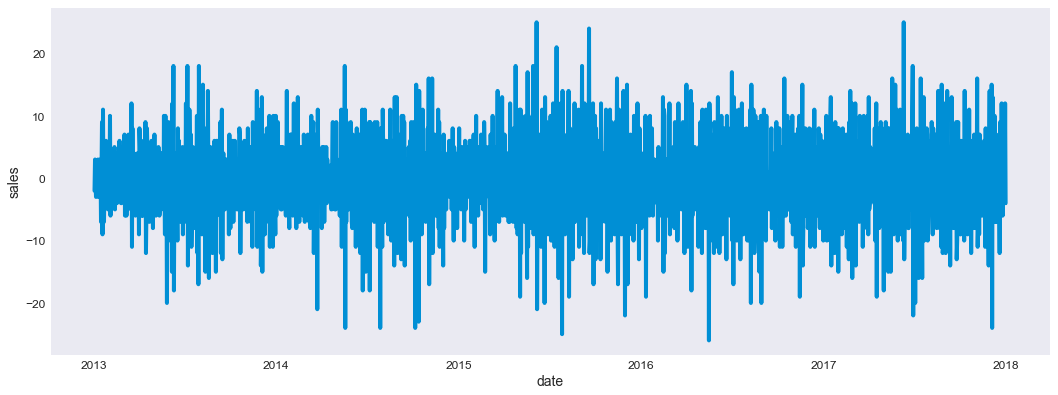

In [19]:
#Plotting the sale_diff column by date
plt.figure(figsize=(16, 6))
sns.lineplot(x=diff_train1.index, y=diff_train1.sales)
dickey_fuller_test(diff_train1['sales'])

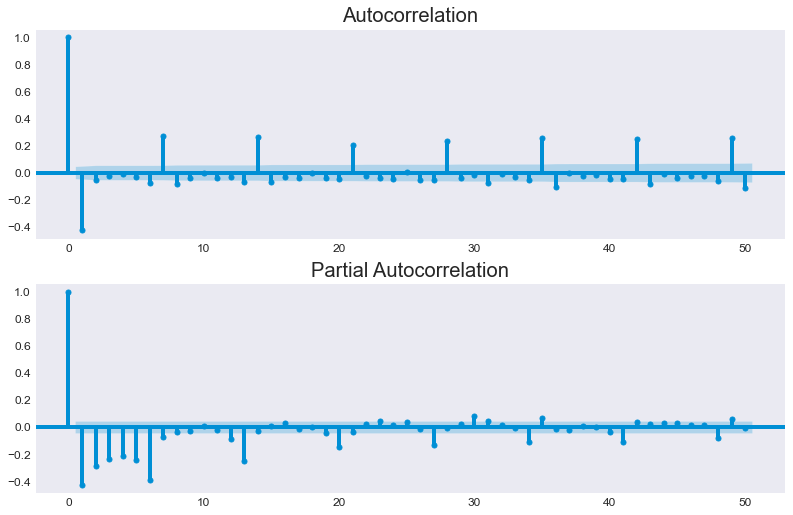

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_acf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_train1['sales'],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_train1['sales'],lags=50, ax=ax2)

After differencing, our data should become stationary. The ADF test confirmed that we removed the trend from it, but we can see a strange pattern on ACF plot, probably indicating that there's still a seasonality pattern.

### Model Building 

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math

In [22]:
print ("Our data in TRAIN dataset starts at:",diff_train.index[0],"and finishes at", diff_train.index[-1], '\n')

Our data in TRAIN dataset starts at: 2013-01-02 00:00:00 and finishes at 2017-12-31 00:00:00 



To train our data, let's try to predict the last year of our train dataset before making predictions into our test dataset

* *Note: We're still going to use just store 1 and item 1 to test our models due to efficiency*

In [23]:
#Splitting the train dataset
train_start, train_end = '2013-1-2','2017-09-30'
test_start, test_end = '2017-10-01','2017-12-31'

#Data with difference()
train_data_diff = diff_train1.loc[train_start:train_end]
test_data_diff = diff_train1.loc[test_start:test_end]

#Non-stationary data
train_data = train1.loc[train_start:train_end]
test_data = train1.loc[test_start:test_end]


print('Train data diff shape:',train_data_diff.shape, '\nTest data diff shape:', test_data_diff.shape, '\n')
print('Train data shape:',train_data.shape, '\nTest data shape:', test_data.shape)

Train data diff shape: (1733, 9) 
Test data diff shape: (92, 9) 

Train data shape: (1733, 9) 
Test data shape: (92, 9)


**METRICS**

* **Mean absolute percentage error (MAPE):**

Expresses accuracy as a percentage of the error. Because this number is a percentage, it can be easier to understand than the other statistics. For example, if the MAPE is 5, on average, the forecast is off by 5%.

* **Mean squared error (MSE):**

The mean squared error, or MSE, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors.

* **Akaike information criterion (AIC):**

AIC is a single number score that can be used to determine which of multiple models is most likely to be the best model for a given dataset. It estimates models relatively, meaning that AIC scores are only useful in comparison with other AIC scores for the same dataset. A lower AIC score is better.

In [24]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return print("MAPE: {}%.".format(mape))

def MSE (Y_actual, Y_Predicted):
    mse = mean_squared_error(Y_actual, Y_Predicted)
    return print("MSE: {}.".format(mse))

**ARMA model:**

Auto-regressive (AR) process, a time series is said to be AR when the present value of the time series can be obtained using previous values of the same time series i.e the actual value is the weighted average of its lags. Stock prices and global temperature rise could be thought of as an AR process.

Moving average (MA), a process where the present value of series is defined as a linear combination of past errors. We assume the errors to be independently distributed between the normal distribution.

**How to find the order of the AR term (p)**:

You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot. For our data, we can start with AR of order 7.

**How to find the order of the MA term (q)**:

Order q of the MA process is obtained from the ACF plot. It's the lag after which ACF crosses the upper confidence interval for the first time. We can start with the MA of order 1 for our data.

In [25]:
#Creating the model
ARMA_model = sm.tsa.statespace.SARIMAX(train_data_diff['sales'], order=(7,0,1), freq='D').fit()

#Predicting test set
pred_ARMA = ARMA_model.predict(train_end,test_end)[1:]

#Printing the results
ARMA_model.summary()

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1733
Model:               SARIMAX(7, 0, 1)   Log Likelihood               -5286.539
Date:                Fri, 16 Apr 2021   AIC                          10591.078
Time:                        14:22:34   BIC                          10640.196
Sample:                    01-02-2013   HQIC                         10609.244
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So our ARMA(7,1) model would be like:

$\hat{y_t} = 0.035y_{t-1} -0.08y_{t-2} -0.08y_{t-3} -0.065y_{t-4} -0.034y_{t-5} 0.006y_{t-6} 0.26y_{t-7} -0.9\varepsilon_{t-1}$

In [26]:
#As we going to create many models, let's make a function to see easily our results.
def predict_plot(pred_name, Y_actual):
    
    #returning MSE and MAPE
    MSE_value = MSE(Y_actual, pred_name)
    MAPE_value = MAPE(Y_actual,pred_name)
    
    #Plotting results
    pd.DataFrame({'test':Y_actual, 'pred':pred_name}).plot()
    return

MSE: 53.3706724706024.
MAPE: inf%.


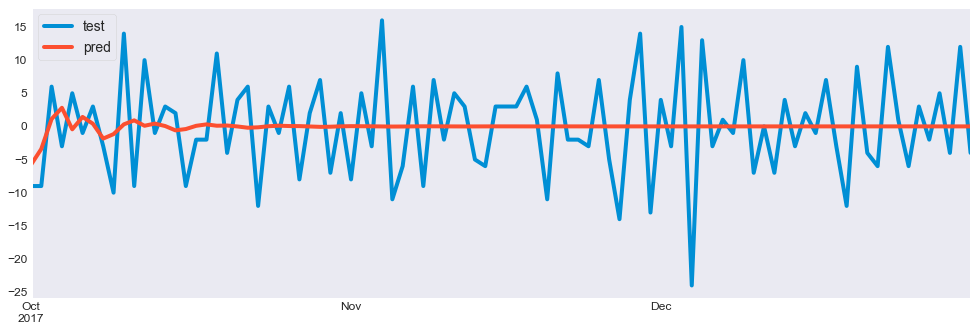

In [27]:
predict_plot(pred_ARMA, test_data_diff['sales'])

We can use arma_order_select_ic to find the parameters to reach the best results using Akaike information criterion (AIC), a quality of statistical models for a given set of data, as the metric. This is not the best way to get the best results for metrics like MAPE, but it'll work for now. We we'll these parameters again before submitting results in this notebook (SARIMAX tuning).

In [28]:
#resDiff = sm.tsa.arma_order_select_ic(train_data['sales'], max_ar=7, max_ma=7, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')
print('ARMA(p,q) = (7, 7) is the best.')

ARMA(p,q) = (7, 7) is the best.


We'll apply these parameters on our next model, ARIMA.

**ARIMA model:**

The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series. Random-walk and random-trend models, autoregressive models, and exponential smoothing models are all special cases of ARIMA models. ARIMA model is of the form: 

A nonseasonal ARIMA model is classified as an **ARIMA(p,d,q)** model, where:

* **p** is the number of autoregressive terms,
* **d** is the number of nonseasonal differences needed for stationarity, and
* **q** is the number of lagged forecast errors in the prediction equation.

In [29]:
#We can use our data without diff and let ARIMA take care of diff
ARIMA_model = sm.tsa.statespace.SARIMAX(train_data['sales'], order=(7,1,7), freq='D', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

#make prediction on test data
pred_ARIMA = ARIMA_model.predict(train_end,test_end)[1:]

#Printing the results on train dataset
ARIMA_model.summary()

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1733
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -5118.035
Date:                Fri, 16 Apr 2021   AIC                          10266.070
Time:                        14:22:42   BIC                          10347.856
Sample:                    01-02-2013   HQIC                         10296.326
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9177      0.031    -29.196      0.000      -0.979      -0.856
ar.L2         -0.9209      0.031    -29.529      0.000      -0.982      -0.860
ar.L3         -0.9218      0.031    -29.780      0.000      -0.982      -0.861
ar.L4         -0.9178      0.032    -29.069      0.000      -0.980      -0.856
ar.L5         -0.9238      0.031    -30.069      0.000      -0.984      -0.864
ar.L6         -0.9177      0.032    -29.004      0.000      -0.980      -0.856
ar.L7          0.0771      0.031      2.506      0.012       0.017       0.137
ma.L1          0.0539      0.142      0.380      0.704      -0.224       0.332
ma.L2          0.1098      0.047      2.352      0.019       0.018       0.201
ma.L3          0.0817      0.193      0.425      0.671      -0.296       0.459
ma.L4          0.0876      0.210      0.417      0.677      -0.324       0.499
ma.L5          0.0934      0.078      1.196      0.232      -0.060       0.246
ma.L6          0.0673      0.110      0.613      0.540      -0.148       0.282
ma.L7         -0.8782      0.198     -4.436      0.000      -1.266      -0.490
sigma2        23.6469      5.455      4.335      0.000      12.956      34.338
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                16.48
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 44.005691868036244.
MAPE: 36.70513713194905%.


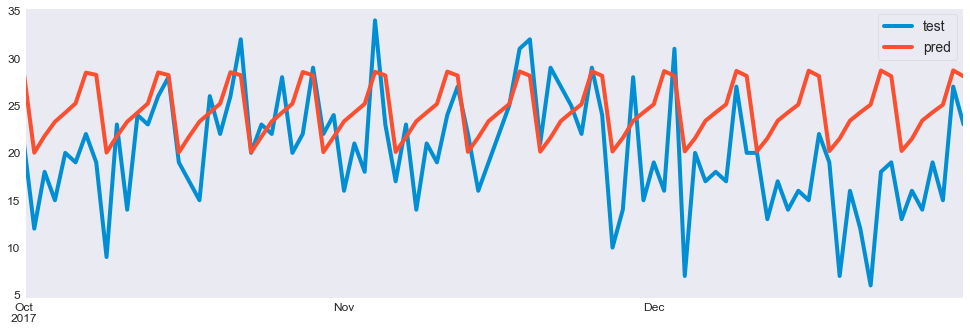

In [30]:
predict_plot(pred_ARIMA, test_data['sales'])

**ARIMAX model**

So far we had seen:
 - **ARMA**: The simplest model that data must be stationary.
 - **ARIMA**: Autoregressive Integrated Moving Average -> Forecast based on the presence of trend
 
So what's the 'X' on **ARIMAX**?

 * X stands for Exogenous Variable, which are variables from outside the model of study that impact the model. Good examples for this type of variable would be holidays, weather, inflation, etc
 
We can create more variables that will help having a better prediction of sales, and we can also use the Time Series variables that we created before, like month, weekofyear, etc.

In [31]:
#Printing all collumns from test data
train1.head()

store  item  sales  year  month  weekofyear  dayofweek  dayofyear  \
date                                                                            
2013-01-01      1     1     13  2013      1           1          1          1   
2013-01-02      1     1     11  2013      1           1          2          2   
2013-01-03      1     1     14  2013      1           1          3          3   
2013-01-04      1     1     13  2013      1           1          4          4   
2013-01-05      1     1     10  2013      1           1          5          5   

            weekend  
date                 
2013-01-01        0  
2013-01-02        0  
2013-01-03        0  
2013-01-04        0  
2013-01-05        1

Let's create lag variables, which is the value from X days before. We'll have to reduce our train data because of these variables, but they'll help us to deal with seasonality.

In [32]:
train1['sales_shifted_182'] = train1.sales.shift(182)
train1['sales_shifted_364'] = train1.sales.shift(364)

To our model read faster and better our exogenous data, we should transform it. We're going to use One-Hot-Enconder (get_dummies) on Month and Day of Week columns.

In [33]:
#month one-hot encoding
month_dummies = pd.get_dummies(train1['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
train1 = pd.concat([train1, month_dummies], axis=1)
train1 = train1.drop('month',axis=1)

#dayofweek one-hot encoding
week_dummies = pd.get_dummies(train1['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
train1 = pd.concat([train1, week_dummies], axis=1)
train1 = train1.drop('dayofweek',axis=1)

#Splitting the train dataset (we reduced one year of training data due to lag variables)
train_start, train_end = '2014-1-1','2017-09-30'
test_start, test_end = '2017-10-01','2017-12-31'

#Updating our train and test variables
train_data = train1.loc[train_start:train_end]
test_data = train1.loc[test_start:test_end]

print('Train data shape:',train_data.shape, '\nTest data shape:', test_data.shape)
train_data.head()

Train data shape: (1369, 28) 
Test data shape: (92, 28)


store  item  sales  year  weekofyear  dayofyear  weekend  \
date                                                                   
2014-01-01      1     1      9  2014           1          1        0   
2014-01-02      1     1     14  2014           1          2        0   
2014-01-03      1     1     11  2014           1          3        0   
2014-01-04      1     1     20  2014           1          4        1   
2014-01-05      1     1     17  2014           1          5        1   

            sales_shifted_182  sales_shifted_364  month-1  ...  month-10  \
date                                                       ...             
2014-01-01               12.0               11.0        1  ...         0   
2014-01-02               24.0               14.0        1  ...         0   
2014-01-03               17.0               13.0        1  ...         0   
2014-01-04               16.0               10.0        1  ...         0   
2014-01-05               34.0               12.0        1  ...         0   

            month-11  month-12  dayofweek-0  dayofweek-1  dayofweek-2  \
date                                                                    
2014-01-01         0         0            0            0            1   
2014-01-02         0         0            0            0            0   
2014-01-03         0         0            0            0            0   
2014-01-04         0         0            0            0            0   
2014-01-05         0         0            0            0            0   

            dayofweek-3  dayofweek-4  dayofweek-5  dayofweek-6  
date                                                            
2014-01-01            0            0            0            0  
2014-01-02            1            0            0            0  
2014-01-03            0            1            0            0  
2014-01-04            0            0            1            0  
2014-01-05            0            0            0            1  

[5 rows x 28 columns]

In [34]:
train_exog = train_data.drop(['store', 'item','sales'],axis=1)
test_exog = test_data.drop(['store', 'item','sales'],axis=1)

In [35]:
#Creating the model
ARIMAX_model = sm.tsa.statespace.SARIMAX(train_data['sales'], order=(7,1,7), exog = train_exog,
                                         seasonal_order=(0,0,0,0), freq='D', enforce_stationarity=False, 
                                         enforce_invertibility=False).fit()

#make prediction on test data
pred_ARIMAX = ARIMAX_model.predict(train_end,test_end, exog=test_exog)[1:]

#Printing the results
ARIMAX_model.summary()

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3987.210
Date:                Fri, 16 Apr 2021   AIC                           8054.419
Time:                        14:22:59   BIC                           8263.029
Sample:                    01-01-2014   HQIC                          8132.515
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
year                  3.1822      2.057      1.547      0.122      -0.849       7.214
weekofyear           -0.0081      0.044     -0.183      0.855      -0.095       0.079
dayofyear             0.0109      0.015      0.729      0.466      -0.018       0.040
weekend               2.7567      0.194     14.200      0.000       2.376       3.137
sales_shifted_182    -0.0646      0.027     -2.396      0.017      -0.118      -0.012
sales_shifted_364     0.0595      0.028      2.113      0.035       0.004       0.115
month-1              -4.0135      2.297     -1.748      0.081      -8.515       0.488
month-2              -4.3177      1.920     -2.249      0.025      -8.081      -0.555
month-3              -2.2855      1.507     -1.517      0.129      -5.238       0.668
month-4               0.1413      1.128      0.125      0.900      -2.069       2.352
month-5               1.6659      0.824      2.021      0.043       0.050       3.281
month-6               2.8615      0.661      4.328      0.000       1.566       4.157
month-7               3.6315      0.726      5.001      0.000       2.208       5.055
month-8               1.3303      0.867      1.534      0.125      -0.370       3.030
month-9               1.9145      1.102      1.737      0.082      -0.246       4.075
month-10              1.7252      1.496      1.153      0.249      -1.207       4.658
month-11              1.8524      1.940      0.955      0.340      -1.949       5.654
month-12             -4.5060      2.328     -1.935      0.053      -9.069       0.057
dayofweek-0          -3.8592      0.353    -10.945      0.000      -4.550      -3.168
dayofweek-1          -0.9167      0.317     -2.887      0.004      -1.539      -0.294
dayofweek-2          -0.2902      0.288     -1.009      0.313      -0.854       0.273
dayofweek-3           0.2132      0.314      0.678      0.497      -0.403       0.829
dayofweek-4           2.0961      0.304      6.897      0.000       1.500       2.692
dayofweek-5           0.8477      0.230      3.687      0.000       0.397       1.298
dayofweek-6           1.9090      0.238      8.010      0.000       1.442       2.376
ar.L1                -1.0095      1.884     -0.536      0.592      -4.703       2.684
ar.L2                -0.6464      1.732     -0.373      0.709      -4.041       2.748
ar.L3                -0.8132      1.171     -0.695      0.487      -3.108       1.481
ar.L4                -0.2324      1.071     -0.217      0.828      -2.331       1.866
ar.L5                -0.0087      0.615     -0.014      0.989      -1.213       1.196
ar.L6                 0.0129      0.705      0.018      0.985      -1.369       1.395
ar.L7                -0.0225      0.060     -0.377      0.707      -0.139       0.095
ma.L1                 0.0521      1.880      0.028      0.978      -3.633       3.737
ma.L2                -0.3840      0.753     -0.510      0.610      -1.861       1.093
ma.L3                 0.1537      1.746      0.088      0.9

MSE: 26.997247809389112.
MAPE: 26.773385329247805%.


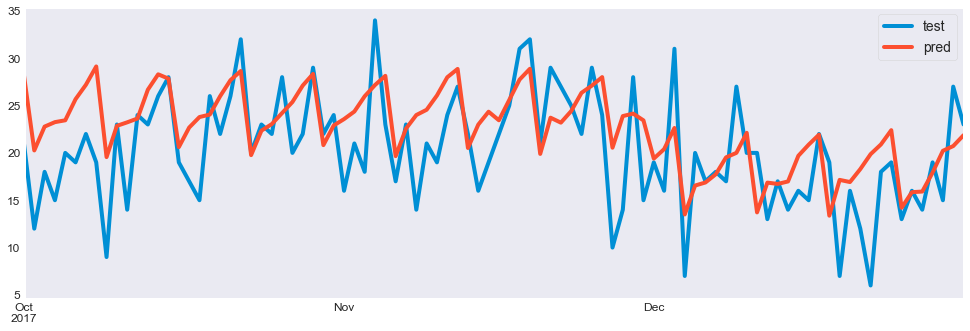

In [36]:
predict_plot(pred_ARIMAX, test_data['sales'])

**SAMIRAX model**

Let's add seasonality to ARIMAX, but first we need to understand what's a SAMIRA model:

**SARIMA models:**

SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented before.

As a quick overview, SARIMA models are ARIMA models with a seasonal component. Per the formula **SARIMA(p,d,q)x(P,D,Q,s)**, the parameters for these types of models are as follows: 

* **p** and seasonal **P**: indicate number of autoregressive terms (lags of the stationarized series)
* **d** and seasonal **D**: indicate differencing that must be done to stationarize series
* **q** and seasonal **Q**: indicate number of moving average terms (lags of the forecast errors)
* **s**: indicates seasonal length in the data. As we have daily data it would be correct to choose 365, but we would have memory problems to run the model. So for now we'll stick with period 7.

Therefore, the SAMIRAX model is a SAMIRA model with exogenous variables. For now we'll stick with low values for our parameters so it can run faster.

In [37]:
#Creating the model
SARIMAX_model = sm.tsa.statespace.SARIMAX(train_data['sales'], order=(1,1,1), seasonal_order=(1,0,1,7),
                                          exog = train_exog, freq='D', 
                                          enforce_stationarity=False, enforce_invertibility=False).fit()
#Predicting test set
pred_SARIMAX = SARIMAX_model.predict(train_end,test_end, exog=test_exog)[1:]

#Printing summary
SARIMAX_model.summary()

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1369
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3986.853
Date:                           Fri, 16 Apr 2021   AIC                           8033.705
Time:                                   14:23:11   BIC                           8190.140
Sample:                               01-01-2014   HQIC                          8092.271
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
year                  3.1596      1.731      1.825      0.068      -0.233       6.552
weekofyear           -0.0159      0.044     -0.365      0.715      -0.101       0.070
dayofyear             0.0113      0.015      0.745      0.456      -0.018       0.041
weekend               2.8227      0.186     15.152      0.000       2.458       3.188
sales_shifted_182    -0.0745      0.026     -2.834      0.005      -0.126      -0.023
sales_shifted_364     0.0616      0.027      2.241      0.025       0.008       0.115
month-1              -4.0872      2.393     -1.708      0.088      -8.778       0.603
month-2              -4.3228      2.003     -2.158      0.031      -8.249      -0.396
month-3              -2.2408      1.562     -1.435      0.151      -5.302       0.821
month-4               0.1033      1.165      0.089      0.929      -2.180       2.386
month-5               1.7004      0.820      2.073      0.038       0.093       3.308
month-6               2.9113      0.646      4.506      0.000       1.645       4.177
month-7               3.7307      0.726      5.139      0.000       2.308       5.153
month-8               1.3929      0.882      1.579      0.114      -0.336       3.122
month-9               1.8327      1.137      1.612      0.107      -0.396       4.061
month-10              1.5739      1.549      1.016      0.310      -1.463       4.611
month-11              1.9374      2.019      0.960      0.337      -2.020       5.895
month-12             -4.5319      2.427     -1.867      0.062      -9.289       0.225
dayofweek-0          -3.8784      0.342    -11.330      0.000      -4.549      -3.207
dayofweek-1          -0.9537      0.310     -3.073      0.002      -1.562      -0.345
dayofweek-2          -0.3330      0.283     -1.175      0.240      -0.888       0.222
dayofweek-3           0.2197      0.305      0.719      0.472      -0.379       0.818
dayofweek-4           2.1226      0.294      7.210      0.000       1.546       2.700
dayofweek-5           0.9141      0.223      4.095      0.000       0.477       1.352
dayofweek-6           1.9086      0.233      8.189      0.000       1.452       2.365
ar.L1                 0.0088      0.029      0.299      0.765      -0.049       0.066
ma.L1                -0.9668      0.011    -86.872      0.000      -0.989      -0.945
ar.S.L7               0.0496      0.975      0.051      0.959      -1.861       1.960
ma.S.L7              -0.0398      0.974     -0.041      0.967      -1.949       1.869
sigma2               19.9680      0.719     27.765      0.000      18.558      21.378
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                28.73
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:  

MSE: 28.260468657857224.
MAPE: 27.4638108571075%.


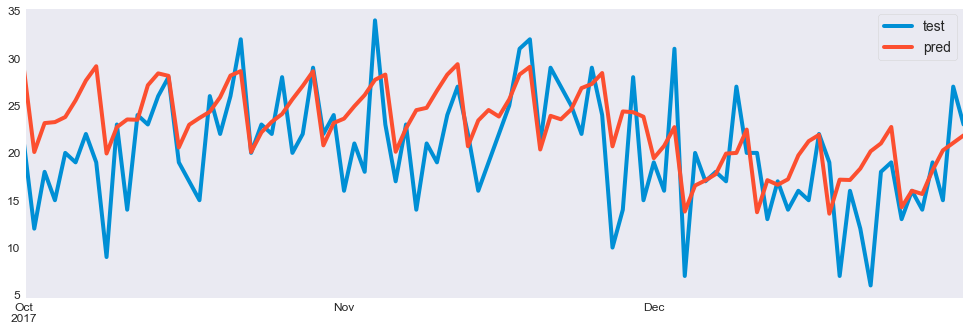

In [38]:
predict_plot(pred_SARIMAX, test_data['sales'])

We got almost the same results when comparing SAMIRAX to ARIMAX, but with a run time a lot higher. We could eventually get better results if we tune our parameters using a good tuning method or Grid Search, but to keep things simple and time efficient, for now we'll stick with ARIMAX so we can check other issues like holidays and residuals.

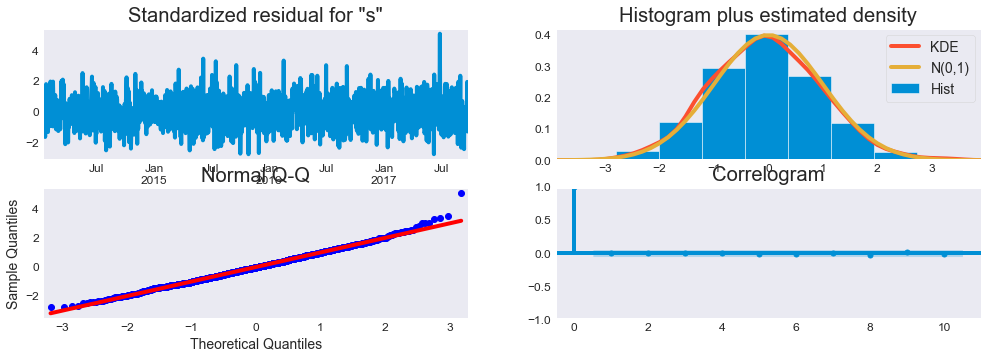

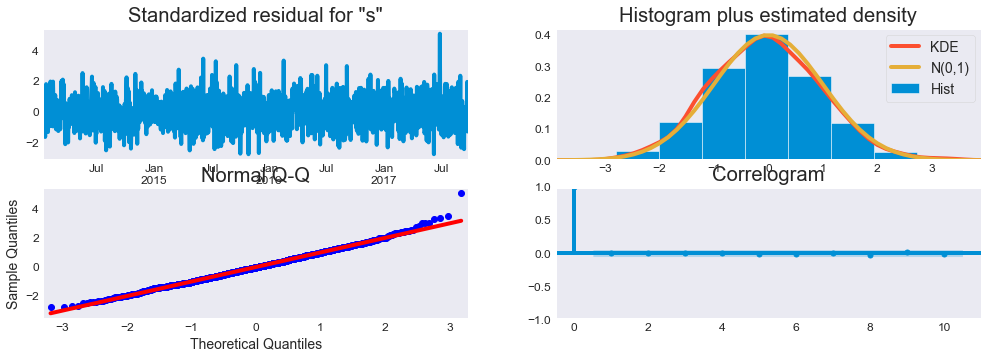

In [39]:
ARIMAX_model.plot_diagnostics()

We can see that our residuals (figure 1) have some variance, probably due to holidays and/or outliers on our data. Let's analyse it.

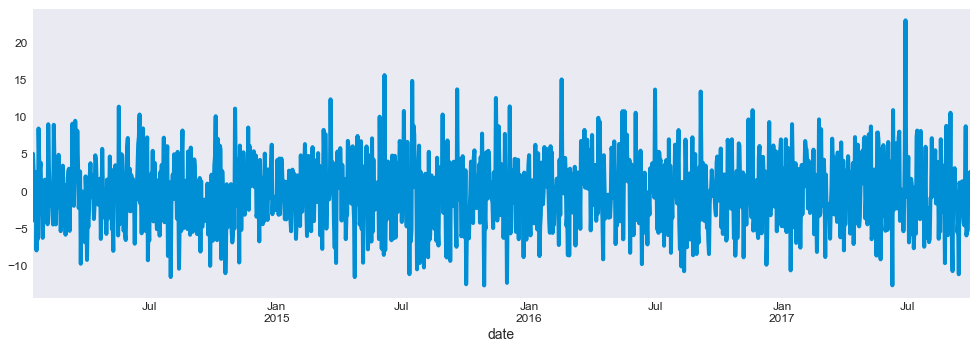

In [40]:
#Printing residuals
ARIMAX_model.resid[10:].plot();plt.show()
res_df_all = pd.DataFrame(ARIMAX_model.resid,columns=['resid'])

In [41]:
#Making a DF for residuals
res_df = pd.DataFrame(ARIMAX_model.resid[70:],columns=['resid'])
res_df.sort_values(by='resid',ascending=False).head(5)

resid
date                 
2017-06-28  22.956561
2015-06-06  15.614682
2016-02-17  15.038107
2015-07-16  14.836533
2015-09-19  13.702686

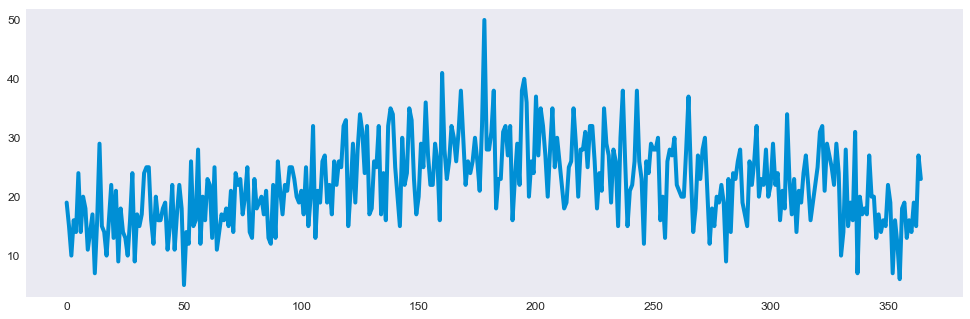

The mean value for sales in 2017 was: 22.183561643835617
The sale value for 2017-06-08 was: 50


In [42]:
#Plotting only year of 2017 values of sale
plt.plot(train1[(train1.index.year==2017)].sales.dropna().values);plt.show()
print('The mean value for sales in 2017 was:', train1[(train1.index.year==2017)].sales.mean())
print('The sale value for 2017-06-08 was: 50')

As we don't know much about our business, it's not too right to change the value of this date to something like the mean of that month or the value from one week before, because we don't know if they had a sale promotion for that day or something like that. Because of this, we'll keep with this "outlier" value.

Let's check residuals per year:

In [43]:
#Printing residuals for each year
print('Mean residual for 2014:',res_df_all[(res_df_all.index.year==2014)][10:].mean(),'\n')
print('Mean residual for 2015:',res_df_all[(res_df_all.index.year==2015)].mean(),'\n')
print('Mean residual for 2016:',res_df_all[(res_df_all.index.year==2016)].mean(),'\n')
print('Mean residual for 2017:',res_df_all[(res_df_all.index.year==2017)].mean(),'\n')

Mean residual for 2014: resid   -0.23285
dtype: float64 

Mean residual for 2015: resid   -0.118751
dtype: float64 

Mean residual for 2016: resid   -0.120601
dtype: float64 

Mean residual for 2017: resid   -0.101741
dtype: float64 



It seems thatthe year that we're facing more issues to predict is 2014. One possibility would be to remove the year of 2014 of our training data to try to get better results, but this probably would cause overfitting issues to our model. If we were trying to get good scores on Kaggle's leaderboard, it would be a good option to give it a shot to see if it increases our model accuracy when submitting results.

**Adding Holidays and superbowls games**

Let's try to add some holiday events to see if we get better results.

In [44]:
#Code from https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet/notebook#Forecast-quality-evaluation

#Adding playoff date
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
#Adding superbowls game date
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25']),
    
  'lower_window': 0,
  'upper_window': 3,
})

#making new DF
holidays_raw = pd.concat((playoffs, superbowls))
holidays = holidays_raw.set_index('ds')
print('DF unique values:',holidays['upper_window'].unique())
holidays.head()

DF unique values: [2 3]


holiday  lower_window  upper_window
ds                                             
2013-01-12  playoff             0             2
2013-07-12  playoff             0             2
2013-12-24  playoff             0             2
2014-01-12  playoff             0             2
2014-07-12  playoff             0             2

In [45]:
#Creating new column in our train1 dataset
train1['holiday'] = 0

#Copying values to train1
train1['holiday'].loc[holidays.index] = holidays['upper_window'].values

#Mapping values to 1 and 2 instead of 3 and 2 and making them int
train1['holiday'] = train1['holiday'].map({3:1, 2:2}).fillna(0).astype(int)

#printing unique values from the new column to see validate
train1['holiday'].unique()

array([1, 0, 2])

In [46]:
#Splitting the train dataset
train_start, train_end = '2014-01-01','2017-09-30'
test_start, test_end = '2017-10-01','2017-12-31'

#Train and test data
train_data = train1.loc[train_start:train_end]
test_data = train1.loc[test_start:test_end]
print('Train data shape:',train_data.shape, '\nTest data shape:', test_data.shape)

#Exog for train and test (must the same length size as our train_data and test_data)
train_exog = train1.drop(['store', 'item','sales'],axis=1)[train_start:train_end].dropna()
test_exog = train1.drop(['store', 'item','sales'],axis=1)[test_start:test_end].dropna()
print('\nTrain exog shape:',train_exog.shape, '\nTest exog shape:', test_exog.shape)

Train data shape: (1369, 29) 
Test data shape: (92, 29)

Train exog shape: (1369, 26) 
Test exog shape: (92, 26)


In [47]:
#Creating the model
ARIMAX_model2 = sm.tsa.statespace.SARIMAX(train_data['sales'], order=(7,1,7), exog = train_exog,
                                         seasonal_order=(0,0,0,0), 
                                         freq='D', enforce_stationarity=False, enforce_invertibility=False).fit()
#Predicting test set
pred_ARIMAX2 = ARIMAX_model2.predict(train_end,test_end, exog=test_exog)[1:]

#Printing summary
ARIMAX_model2.summary()

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3987.716
Date:                Fri, 16 Apr 2021   AIC                           8057.431
Time:                        14:23:30   BIC                           8271.256
Sample:                    01-01-2014   HQIC                          8137.479
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
year                  3.1994      2.037      1.571      0.116      -0.793       7.192
weekofyear           -0.0109      0.043     -0.251      0.802      -0.096       0.074
dayofyear             0.0112      0.015      0.742      0.458      -0.018       0.041
weekend               2.7602      0.198     13.957      0.000       2.373       3.148
sales_shifted_182    -0.0652      0.028     -2.367      0.018      -0.119      -0.011
sales_shifted_364     0.0656      0.029      2.268      0.023       0.009       0.122
month-1              -4.0240      2.359     -1.706      0.088      -8.647       0.599
month-2              -4.3200      1.972     -2.191      0.028      -8.185      -0.455
month-3              -2.3568      1.546     -1.524      0.127      -5.387       0.674
month-4               0.1814      1.155      0.157      0.875      -2.082       2.445
month-5               1.6209      0.837      1.936      0.053      -0.020       3.262
month-6               2.8044      0.673      4.170      0.000       1.486       4.123
month-7               3.6719      0.743      4.945      0.000       2.217       5.127
month-8               1.2752      0.893      1.429      0.153      -0.474       3.025
month-9               1.9468      1.130      1.723      0.085      -0.268       4.162
month-10              1.8052      1.537      1.174      0.240      -1.208       4.818
month-11              1.8386      1.992      0.923      0.356      -2.067       5.744
month-12             -4.4435      2.390     -1.859      0.063      -9.127       0.240
dayofweek-0          -3.8371      0.367    -10.467      0.000      -4.556      -3.119
dayofweek-1          -0.9305      0.326     -2.854      0.004      -1.569      -0.291
dayofweek-2          -0.3022      0.293     -1.031      0.303      -0.877       0.273
dayofweek-3           0.2157      0.321      0.671      0.502      -0.414       0.846
dayofweek-4           2.0937      0.310      6.747      0.000       1.486       2.702
dayofweek-5           0.8531      0.235      3.623      0.000       0.392       1.315
dayofweek-6           1.9071      0.244      7.831      0.000       1.430       2.384
holiday              -0.7399      0.488     -1.517      0.129      -1.696       0.216
ar.L1                -1.0240      2.183     -0.469      0.639      -5.303       3.255
ar.L2                -0.6594      1.980     -0.333      0.739      -4.540       3.222
ar.L3                -0.7921      1.645     -0.481      0.630      -4.017       2.433
ar.L4                -0.2709      1.237     -0.219      0.827      -2.695       2.154
ar.L5                -0.0457      0.718     -0.064      0.949      -1.452       1.361
ar.L6                 0.0355      0.815      0.044      0.965      -1.562       1.633
ar.L7                -0.0190      0.072     -0.262      0.793      -0.161       0.123
ma.L1                 0.0629      2.219      0.028      0.977      -4.286       4.412
ma.L2                -0.3770      0.966     -0.390      0.6

MSE: 26.998366691514335.
MAPE: 26.69835880195094%.


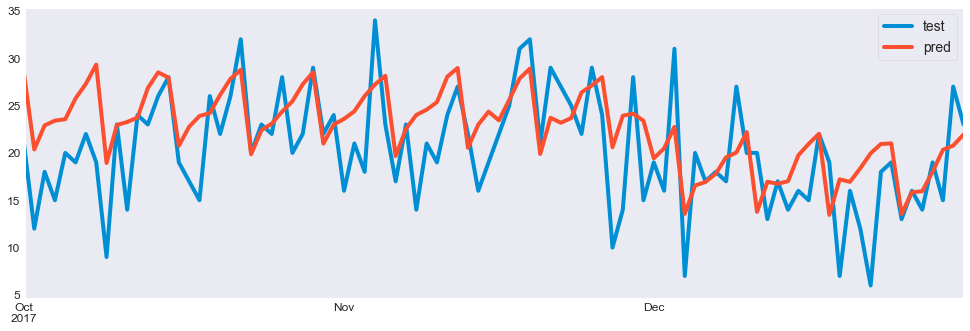

In [48]:
predict_plot(pred_ARIMAX2, test_data['sales'])

We get good results with a simple ARIMAX model on our validation dataset. We could try to improve this result by doing some of the following things:
* Tune parameters using Bayesian Optimisation (SARIMAX)
* Try new lag-based features
* Add new exogenous variables, like climate data source.

But for now we'll leave SARIMAX behind and try a new type of model, using tree boosting to make the prediction.

**XGBoost**

  "*XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solves many data science problems in a fast and accurate way. The same code runs on the major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples*."   -> https://xgboost.readthedocs.io/en/latest/

XGBoost is one of the most popular machine learning algorithms in these days, regardless of the type of prediction task that you're trying to achieve. This model uses Trees as base learners, so we'll have to find the best parameters like max_depth, learning_rate, and many others. Without any more further ado, let's build this model:

In [49]:
import xgboost as xgb
from xgboost import plot_importance
from skopt import forest_minimize
from sklearn.model_selection import cross_val_score

In [50]:
#Making variables for train dataset
X_train = train_exog
y_train = train_data['sales']

#Making variables for test dataset
X_test = test_exog
y_test = test_data['sales']

#Printing shape for each variable
print('X_train shape:', X_train.shape,'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape,'y_test shape:', y_test.shape)

X_train shape: (1369, 26) y_train shape: (1369,)
X_test shape: (92, 26) y_test shape: (92,)


In [51]:
#Creating our XGB model
reg = xgb.XGBRegressor(n_estimators=1000, random_state=1)

#Fitting
reg.fit(X_train, y_train, verbose=False)

#Predicting test set
pred_XGB = reg.predict(X_test)

MSE: 31.436551589372684.
MAPE: 26.570690338516638%.


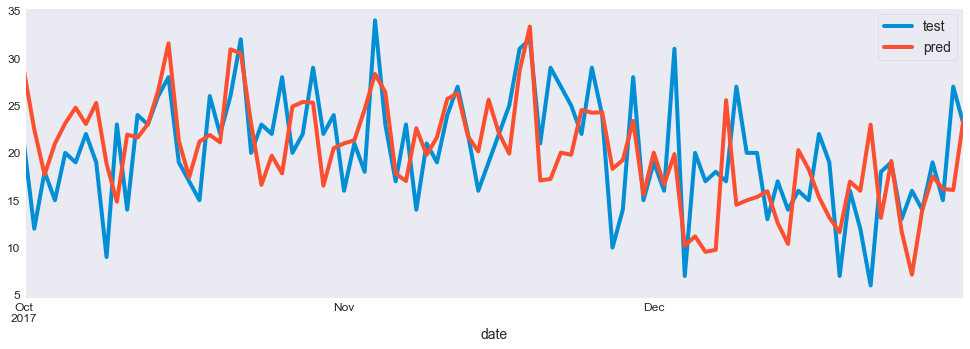

In [52]:
#Predicting test set
predict_plot(pred_XGB, test_data['sales'])

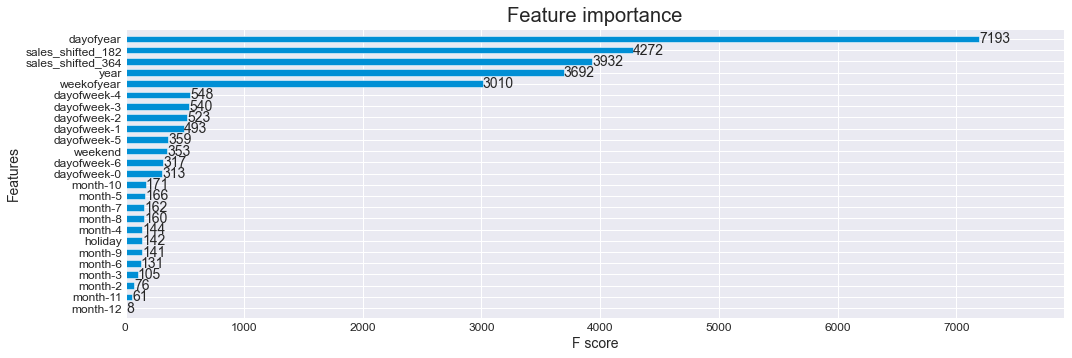

In [53]:
#Plotting feature importance -> Saving results in a temporary variable (_)
_ = plot_importance(reg, height=0.6)

That's a great initial result! Let's improve it by tuning a little XGB with **sequential optimisation using decision trees.**

- What's this type of tuning? 

"*A tree based regression model is used to model the expensive to evaluate function func. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of func with as few evaluations as possible.* -> https://scikit-optimize.github.io/stable/modules/generated/skopt.forest_minimize.html 

In [54]:
# From: https://www.youtube.com/watch?v=WhnkeasZNHI&t=1524s&ab_channel=MarioFilho
# Using a random forest to optimize
def tune_xgbr(params):

    
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    subsample = params[3]
    gamma = params[4]
    min_child_weight = params[5]

    print(params, '\n')
    #Model to be optimized
    mdl = xgb.XGBRegressor(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth,
                       subsample = subsample, gamma = gamma, min_child_weight = min_child_weight, 
                       random_state=1)

    #Cross-Validation in order to avoid overfitting
    mse = cross_val_score(mdl, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
    mse = (-mse)
    print(mse.mean())
    return mse.mean()

In [55]:
# Creating a sample space in which the initial randomic search should be performed
param_grid = [(0.01, 0.3, 'log-uniform'), # learning rate
          (100, 8000), # n_estimators
          (1, 6), # max_depth 
          (0.1, 1.0), #subsample
          (0.001, 1.2), #gamma
          (0, 10)] #min_child_weig ht
         
# Minimization using a random forest with 10 random samples and 40  iterations for forest minimize optimization.
#result = forest_minimize(tune_xgbr, param_grid, random_state=1, n_calls=50, n_initial_points=10, n_jobs=-1, verbose=3)

Let's take our best parameters and test it on our validation dataset:

MSE: 24.25883592623244.
MAPE: 24.401264558166226%.


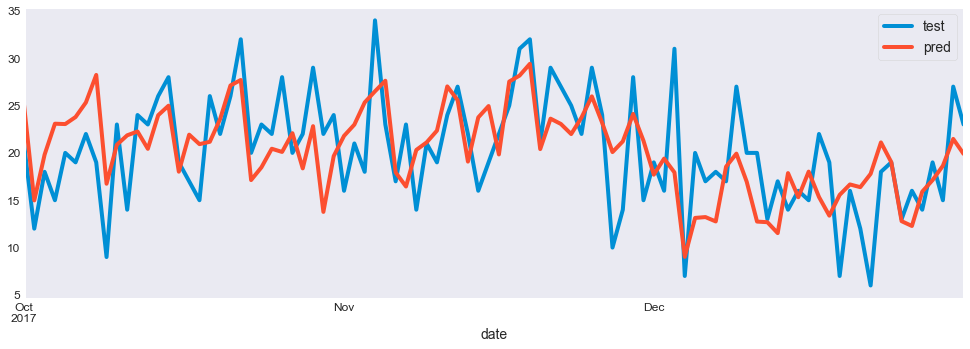

In [56]:
#Best parameters:
#[0.28494957015769784, 2900, 1, 0.20390897060285537, 0.17107666175928699, 3] 

#Creating model
reg = xgb.XGBRegressor(learning_rate = 0.28495, n_estimators = 2900, max_depth = 1,
                       subsample = 0.203909, gamma = 0.1710767, min_child_weight = 3, 
                       random_state=1)
#Fitting
reg.fit(X_train, y_train, verbose=False)

#Predicting test set
pred_XGB2 = reg.predict(X_test)

#Plotting and printing results
predict_plot(pred_XGB2, y_test)

XGBoost got a better MSE result than the ARIMAX model with few lines of code. This is one of the many reasons that makes XGB is such a popular model.

Another cool thing is that we used cross-validation to tune our parameters, which reduces a lot the chances of having an overfitted model. Cross-validation can be used to validate all types of models,  including those that we've used before on this notebook, but because we trained models with just a few parameters and we aren't going to use them to make our final predictions, it wouldn't make much difference as it makes on XGBoost and it would take more time to train them.

**Prophet**

 "*Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Prophet is open source software released by Facebook's Core Data Science team. It is available for download on CRAN and PyPI." -> https://github.com/facebook/prophet*

In [57]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [58]:
#We need to adjust our data to what Prophet asks so we can fit our model into it.
_ = {'ds': y_train.index.values, 'y':y_train.values}

y_train_prophet = pd.DataFrame(data=_)
y_train_prophet.head()

ds   y
0 2014-01-01   9
1 2014-01-02  14
2 2014-01-03  11
3 2014-01-04  20
4 2014-01-05  17

In [59]:
# Creating Prophet model
mdl = Prophet(interval_width=0.95)

# Fitting
mdl.fit(y_train_prophet)

# Making prediction for 3 months after training data finishes (validation data range)
pred_time = 92

# Predicting
future_dates = mdl.make_future_dataframe(periods=pred_time, freq='D')
forecast = mdl.predict(future_dates)

# We predicted for our whole dataset, to compare our predictions against test data, we'll have to make a new 
# DF with the last 92 values, take only the predicted value column,
# set date to index and transform it to a series type.
forecast_test = forecast[-92:][['ds', 'yhat']]
forecast_test = forecast_test.set_index('ds')
forecast_test = forecast_test.squeeze()

# Printing results
forecast_test.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
2017-10-01    27.311767
2017-10-02    18.656182
2017-10-03    21.575149
2017-10-04    22.283429
2017-10-05    22.988363
Name: yhat, dtype: float64

MSE: 21.985497808306967.
MAPE: 23.837589201765127%.


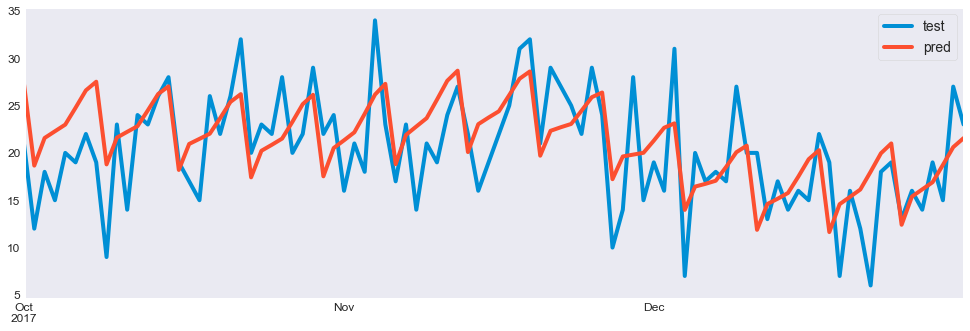

In [60]:
predict_plot(forecast_test, y_test)

In [61]:
plot_plotly(mdl, forecast)

* Black points = actual values
* Dark blue line - predicted values
* Light blue - Upper Yhat and lower y hat

Let's try to add some paremeters to Prophet like Holidays and seasonality to see if we can get a better result.

In [62]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays_raw = pd.concat((playoffs, superbowls))

In [63]:
#Creating model
mdl = Prophet(interval_width=0.95, seasonality_mode = 'additive', holidays=holidays_raw,
             yearly_seasonality=False).add_seasonality(name='yearly',
                                                       period=364,
                                                       fourier_order=20)
#Fitting
mdl.fit(y_train_prophet)

#Making prediction for 3 months (validation data range)
pred_time = 92

#Predicting
future_dates = mdl.make_future_dataframe(periods=pred_time, freq='D')
forecast = mdl.predict(future_dates)

#Making predict series
forecast_test2 = forecast[-92:][['ds', 'yhat']]
forecast_test2 = forecast_test2.set_index('ds')
forecast_test2 = forecast_test2.squeeze()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 20.966180054038613.
MAPE: 22.550299968105563%.


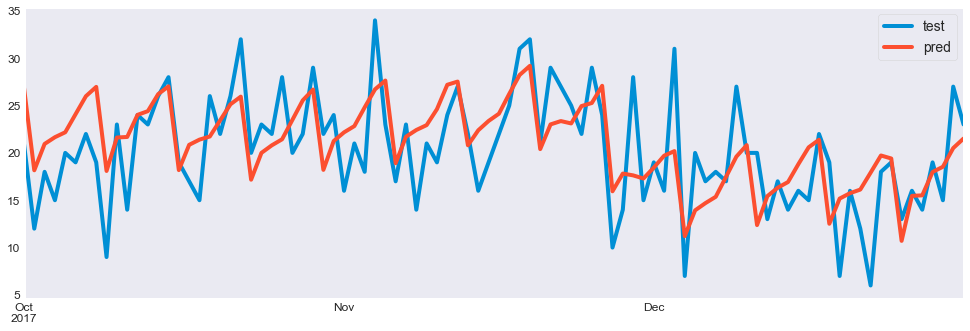

In [64]:
predict_plot(forecast_test2, y_test)

**Results for each model on validation dataset**:
* **ARIMAX**: MSE = 27.41 / MAPE = 26.97%
* **XGBoost**: MSE = 21.985 / MAPE = 23.84%
* **Prophet**: MSE = 20.96 / MAPE = 22.55%

**Tuning SARIMAX**

We may try to tune SARIMAX to see if it can get better results than the ARIMAX model that we had used before. We can either use the brute way by grid searching all parameters, which would take a long time, or we can use other methods, like sequential optimization using decision trees that we had used on XGBoost. I'll show both ways of doing it, but I'll use just forest_minimize since it would take too much time to run the grid search method, although it could give better results.

Feel free to try gridsearch on your machine.

In [65]:
##########################   GRIDSEARCH  ###################################

# import itertools

# p = q = range(1,6) 
# pdq = list(itertools.product(p, [1], q)) 

# sp = sq = range(1,8)
# seasonal_pdq = list(itertools.product(sp, [0], sq, [7]))


# params = [] 
# params_s = [] 
# aics = [] 
# mses = [] 
# mapes = []

# for param in pdq: 
#     for param_seasonal in seasonal_pdq:
#             mod = sm.tsa.statespace.SARIMAX(train_data['sales'], order=param, exog = train_exog, seasonal_order=param_seasonal,
#                                             freq='D', enforce_stationarity=False, enforce_invertibility=False).fit()

#             pred = mod.predict(train_end,test_end, exog=test_exog)[1:]
            
#             #returning MSE and MAPE
#             MSE_value = MSE(y_test, pred)
#             MAPE_value = MAPE(y_test,pred)

#             params.append(param)
#             params_s.append(param_seasonal)
#             aics.append(mod.aic)
#             mses.append(MSE_value)
#             mapes.append(MAPE_value)
            
#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, mod.aic))

In [66]:
##########################  FOREST MINIMIZE ###################################
def tune_sarimax(params):
    
    #Our parameters
    p = params[0] 
    q = params[1] 
    sp = params[2]
    sd = params[3]
    sq = params[4]
    
    d = (1)
    s = (7)
    
    print()
    print('Order=({},1,{}) // Seasonal_Order=({},{},{},7)'.format(params[0],params[1],params[2],params[3],params[4]), '\n')
    
    #Model to be optimized
    mod = sm.tsa.statespace.SARIMAX(y_train, exog = X_train,  
                                    freq='D', enforce_stationarity=False, enforce_invertibility=False,
                                    order=(p,d,q), seasonal_order=(sp,sd,sq,s)).fit()
    #Predicting
    pred = mod.predict(train_end,test_end, exog=X_test)[1:]
    
    #Printing results (MSE,AIC and MAPE)
    MSE_value = MSE(y_test, pred)
    MAPE_value = MAPE(y_test,pred)
    
    #return MAPE value
    return np.mean(np.abs((y_test - pred)/y_test))*100

In [67]:
# Creating a sample space in which the initial randomic search should be performed
param_grid = [(1,6), # p
              (1,6), # q
              (1,7), # sp
              (0,1), #sdm  
              (1,7)] #sq
         
# Minimization using a random forest with 10 random samples and 40  iterations for forest minimize optimization.
# result = forest_minimize(tune_sarimax, param_grid, random_state=1, n_calls=50, n_initial_points=10, n_jobs=-1, verbose=3)

**Best parameters for SARIMAX:** Order=(5,1,5) // Seasonal_Order=(1,1,2,7) 
* MSE: 23.160459696051024.
* MAPE: 23.235999349053493%.

Let's run our model with our new parameters and plot it:

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



MSE: 23.160459696051024.
MAPE: 23.235999349053493%.


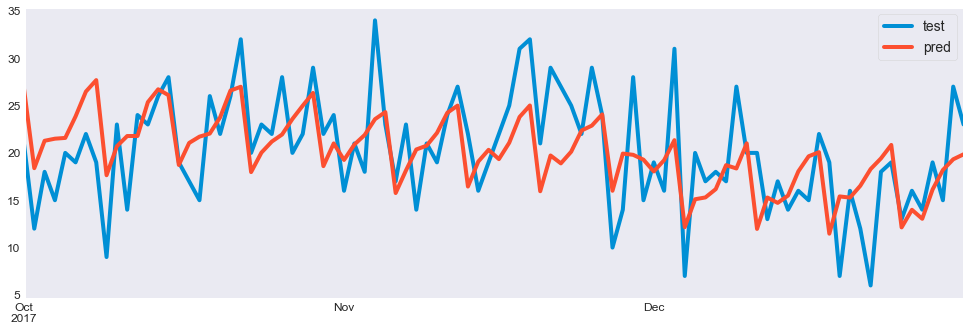

In [68]:
#Creating the model
SARIMAX_model2 = sm.tsa.statespace.SARIMAX(y_train, order=(5,1,5), seasonal_order=(1,1,2,7),
                                          exog=X_train, freq='D', 
                                          enforce_stationarity=False, enforce_invertibility=False).fit()
#Predicting test set
pred_SARIMAX2 = SARIMAX_model2.predict(train_end,test_end, exog=X_test)[1:]


#Printing summary
SARIMAX_model2.summary()

#Predicting
predict_plot(pred_SARIMAX2, y_test)

**Results for each model on validation dataset**:
* **SARIMAX**: MSE = 23.16 / MAPE = 26.97%
* **XGBoost**: MSE = 21.985 / MAPE = 23.84%
* **Prophet**: MSE = 20.96 / MAPE = 22.55%

# Predictions on test dataset - Submitting results

Let's try to submit our best two models (Prophet and XGBoost) to see which one performs better on new data.

* First we'll need to make the same transformations that we made on train dataset to our test dataset.
* After we're done, we'll submit all models to Kaggle's Leaderboard to compare results.

In [69]:
#Loading again our data
train = pd.read_csv('C:/Kaggle/train.csv')
test = pd.read_csv('C:/Kaggle/test.csv')

#Making a concat df so we can train our data and predict only test months
df_concat = pd.concat([train,test],sort=True)

#Changing dtype to datetime
df_concat['date'] = pd.to_datetime(df_concat['date'], format="%Y-%m-%d")

#Creating date features
df_concat.loc[:, 'year'] = df_concat['date'].dt.year #Making year column
df_concat.loc[:, 'month'] = df_concat['date'].dt.month #Month column
df_concat.loc[:, 'weekofyear'] = df_concat['date'].dt.week #Week number of the year column
df_concat.loc[:, 'dayofweek'] = df_concat['date'].dt.dayofweek #Day of the week column
df_concat.loc[:, 'dayofyear'] = df_concat['date'].dt.dayofyear #Day of year
df_concat.loc[:, 'weekend'] = (df_concat.date.dt.weekday >= 5).astype(int) #Check if it's weekend or not

#Date column as Index
df_concat = df_concat.set_index('date')

Should we model all data combined or we create a model for each item and each store? Let's try to find the answer.

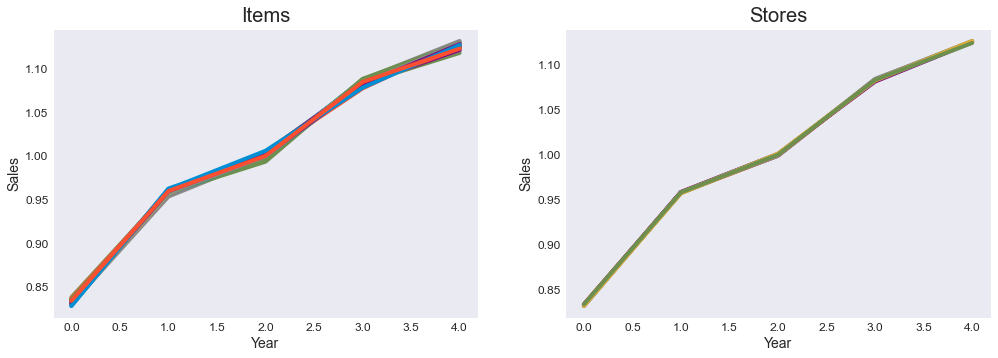

In [70]:
agg_item_year = pd.pivot_table(df_concat, index='year', columns='item',values='sales', 
                              aggfunc=np.mean).values
agg_store_year = pd.pivot_table(df_concat, index='year', columns='store', values='sales', 
                               aggfunc=np.mean).values

#Figure Items
plt.subplot(121)
plt.plot(agg_item_year / agg_item_year.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Sales")

#Figure Stores
plt.subplot(122)
plt.plot(agg_store_year / agg_store_year.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

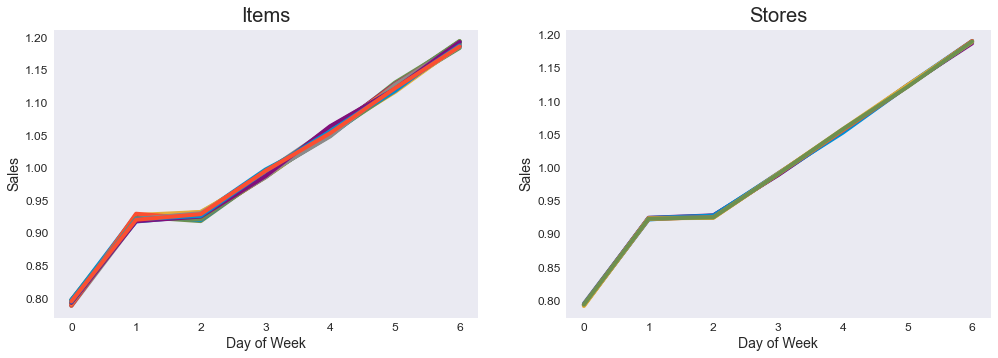

In [71]:
agg_item_weekday = pd.pivot_table(df_concat, index='dayofweek', columns='item',values='sales', 
                              aggfunc=np.mean).values
agg_store_weekday = pd.pivot_table(df_concat, index='dayofweek', columns='store', values='sales', 
                               aggfunc=np.mean).values

#Figure Items
plt.subplot(121)
plt.plot(agg_item_weekday / agg_item_weekday.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Sales")

#Figure Stores
plt.subplot(122)
plt.plot(agg_store_weekday / agg_store_weekday.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Sales")
plt.show()

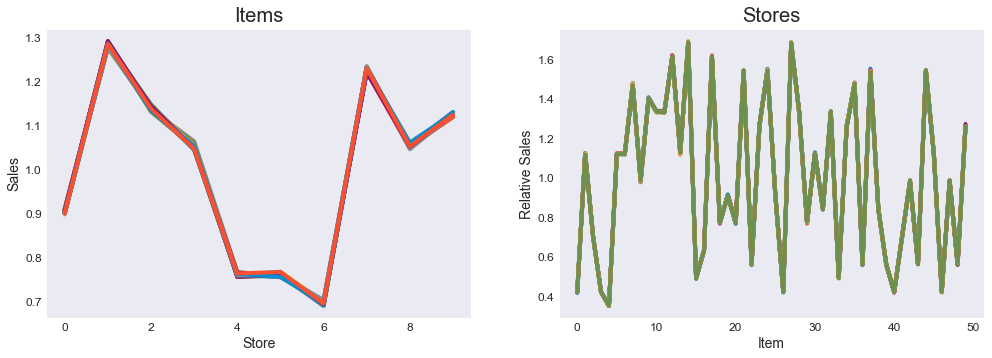

In [72]:
agg_item_store = pd.pivot_table(df_concat, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

#Plotting
plt.subplot(121)
plt.plot(agg_item_store / agg_item_store.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Sales")

plt.subplot(122)
plt.plot(agg_item_store.T / agg_item_store.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

It seems that that all stores has a very stable relative sales factor, unlike what we see on Items, which has a larger spread. If our goal was to get a model that runs quite fast, we could train a model for each item and replicate for every store instead of creating a model for each item of each store.

So let's finish our test data and build our predictions for SARIMAX, Prophet and XGBoost and compare their results.

In [73]:
#shifts
shifts = [182,364]
for s in shifts:
    df_concat['store_item_shifted-'+str(s)] = df_concat.groupby(
        ["item","store"])['sales'].transform(lambda x:x.shift(s))
    
#month one-hot encoding
month_dummies = pd.get_dummies(df_concat['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df_concat = pd.concat([df_concat, month_dummies], axis=1)
df_concat = df_concat.drop('month',axis=1)

#dayofweek one-hot encoding
week_dummies = pd.get_dummies(df_concat['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df_concat = pd.concat([df_concat, week_dummies], axis=1)
df_concat = df_concat.drop('dayofweek',axis=1)


train_start, train_end = '2014-1-1','2017-12-31'
test_start, test_end = '2018-01-01','2018-03-31'

train_data = df_concat.loc[train_start:train_end]
test_data = df_concat.loc[test_start:test_end]

In [74]:
#Adding playoff date
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
#Adding superbowls game date
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25']),
    
  'lower_window': 0,
  'upper_window': 3,
})

#making new DF
holidays_raw = pd.concat((playoffs, superbowls))

**Prophet**

In [75]:
# ########## PROPHET PREDICTION ##########
# resultsProphet = []


# for item in range(1,51):
#     for store in range(1,11):
    
#         #Making new df for X store and Y item
#         df_train = train_data[(train_data.item==item)&(train_data.store==store)].copy()
        
#         ########## VARIABLES FOR TRAIN ##########
#         #Target train
#         y_train = df_train['sales'].copy()
#         _ = {'ds': y_train.index.values, 'y':y_train.values}
#         y_train_prophet = pd.DataFrame(data=_)

#         ########## MODEL BUILDING ##########
#         #Creating model
#         mdl = Prophet(interval_width=0.95, seasonality_mode = 'additive', holidays=holidays_raw,
#                      yearly_seasonality=False).add_seasonality(name='yearly',
#                                                                period=364,
#                                                                fourier_order=20)
#         #Fitting
#         mdl.fit(y_train_prophet)

#         #Making prediction for just 3 months (test data range)
#         pred_time = 90

#         #Predicting
#         future_dates = mdl.make_future_dataframe(periods=pred_time, freq='D')
#         forecast = mdl.predict(future_dates)
#         forecast_test2 = forecast[-90:][['ds', 'yhat']]
#         forecast_test2 = forecast_test2.set_index('ds')
#         forecast_test2 = forecast_test2.squeeze()

#         #Saving results and printing for each item and store predicted
#         resultsProphet.extend(forecast_test2)
#         print('item:',item,'store:',store,'Finished.')

In [76]:
# sub['sales'] = resultsProphet
# sub.to_csv('submission.csv',index=False)
# sub.head()

**SCORE PROHET:**
* Private: 14.08
* Public: 15.93

**XGBoost**

In [77]:
# ####### XGBOOST PREDICTION #######
# resultsXGB = []


# for item in range(1,51):
#     for store in range(1,11):
    
#         #Making new df for X store and Y item
#         df_train = train_data[(train_data.item==item)&(train_data.store==store)].copy()
#         df_test = test_data[(test_data.item==item)&(test_data.store==store)].copy()

#         ########## VARIABLES FOR TRAIN ##########
#         #Target train
#         y_train = df_train['sales']
#         #Exog for train
#         X_train = df_train.drop(['id','store','item','sales'],axis = 1)
        
#         ########## VARIABLE FOR TEST ##########
#         #Exog for test
#         X_test = df_test.drop(['id','store','item','sales'],axis = 1)

#         ########## MODEL BUILDING ##########
#        #Creating model
#         reg = xgb.XGBRegressor(learning_rate = 0.28495, n_estimators = 2900, max_depth = 1,
#                                subsample = 0.203909, gamma = 0.1710767, min_child_weight = 3, 
#                                random_state=1)
#         #Fitting
#         reg.fit(X_train, y_train, verbose=False)

#         #Predicting test set
#         pred_XGB = reg.predict(X_test)

#         #Saving results and printing for each item and store predicted
#         resultsXGB.extend(pred_XGB)
#         print('item:',item,'store:',store,'Finished.')


In [78]:
# sub['sales'] = resultsXGB
# sub.to_csv('submission.csv',index=False)
# sub.head()

**SCORE XGBOOST:**
* Private: 13.90
* Public: 16.06

Final results:
* Prophet: Private = 14.08 // Public = 15.93
* XGBoost: Private = 13.90 // Public = 16.06

**Conclusion**

If we had more domain knowledge, models like XGboost that takes exogenous variables into account probably would have a good improvement once we added new features that makes sense to our business, like marketing campaings and so on. As we don't have too much knowledge about it, we got similar results with models like Prophet.

Things that we could still do to improve our score:
* Stacking and Ensemble.
* Create more exogenous features
* More lag features
* Add more regression models to our stacking
* Try out deep learning since we have a huge dataset.

Thanks a lot for reaching this point of the notebook!!

If you see anything wrong or something that could be improved, please, tell me :)